# Time Series Exploration of Pick data

### Environment setup

In [1]:
import acquire
import prepare
import wrangle_pick
import summarize
import explore
import model

import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics

from scipy.stats import entropy

import matplotlib.dates as mdates #to format dates on our plots

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

explore.set_plotting_defaults()

# Wrangle

In [2]:
train, test, validate = wrangle_pick.wrangle_pick_data()
train.shape, test.shape, validate.shape

Acquire: downloading raw data files...
Acquire: Completed!
Prepare: Cleaning acquired data...
Prepare: Completed!


((96644, 17), (20065, 17), (17055, 17))

In [3]:
# create df for explore
exp = train.copy()

In [6]:
exp.sample(25)

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,start_Y_M,sec_per_box,lines_per_box,sec_per_line
129655,DP,5,1,2019-12-03 09:19:31,2019-12-03 09:21:08,0 days 00:01:37,97.0,3,Tuesday,2019,12,49,9,2019-12,97.0,5.0,19.400000
71362,DP,3,1,2017-05-06 13:19:30,2017-05-06 13:20:20,0 days 00:00:50,50.0,6,Saturday,2017,5,18,13,2017-05,50.0,3.0,16.666667
59547,AH,3,1,2017-01-19 10:10:11,2017-01-19 10:10:49,0 days 00:00:38,38.0,19,Thursday,2017,1,3,10,2017-01,38.0,3.0,12.666667
66707,AH,2,1,2017-10-04 16:43:23,2017-10-04 16:43:53,0 days 00:00:30,30.0,4,Wednesday,2017,10,40,16,2017-10,30.0,2.0,15.000000
141144,IT,6,1,2019-07-17 10:23:34,2019-07-17 10:25:09,0 days 00:01:35,95.0,17,Wednesday,2019,7,29,10,2019-07,95.0,6.0,15.833333
29631,PICKER,8,1,2016-03-18 13:20:25,2016-03-18 13:23:30,0 days 00:03:05,185.0,18,Friday,2016,3,11,13,2016-03,185.0,8.0,23.125000
93226,DP,5,1,2018-01-30 10:19:50,2018-01-30 10:20:44,0 days 00:00:54,54.0,30,Tuesday,2018,1,5,10,2018-01,54.0,5.0,10.800000
108929,IT,4,1,2018-07-31 14:24:16,2018-07-31 14:25:06,0 days 00:00:50,50.0,31,Tuesday,2018,7,31,14,2018-07,50.0,4.0,12.500000
71192,IT,3,1,2017-02-06 10:55:13,2017-02-06 10:56:08,0 days 00:00:55,55.0,6,Monday,2017,2,6,10,2017-02,55.0,3.0,18.333333
26128,SAM,5,1,2016-10-02 13:35:42,2016-10-02 13:35:55,0 days 00:00:13,13.0,2,Sunday,2016,10,39,13,2016-10,13.0,5.0,2.600000


In [5]:
# create df for time series exploration
ts = train.copy()

# Non-TS index Explore

## Prep explore dataframe

In [7]:
exp1 = exp[['total_lines', 'total_boxes', 'pick_seconds', 'operator', 'hour', 'day', 'day_name', 
            'week', 'month', 'year', 'sec_per_box', 'lines_per_box', 'sec_per_line' ]]

In [8]:
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
50058,3,1,119.0,IT,9,10,Thursday,45,11,2016,119.0,3.0,39.666667
78958,71,1,1667.0,IT,8,22,Tuesday,34,8,2017,1667.0,71.0,23.478873
72775,3,1,234.0,JS,16,19,Monday,25,6,2017,234.0,3.0,78.000000
68159,4,1,382.0,IT,16,27,Thursday,17,4,2017,382.0,4.0,95.500000
96678,2,1,24.0,HB,12,15,Thursday,11,3,2018,24.0,2.0,12.000000


In [9]:
exp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96644 entries, 50058 to 40898
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_lines    96644 non-null  int64  
 1   total_boxes    96644 non-null  int64  
 2   pick_seconds   96644 non-null  float64
 3   operator       96644 non-null  object 
 4   hour           96644 non-null  int64  
 5   day            96644 non-null  int64  
 6   day_name       96644 non-null  object 
 7   week           96644 non-null  int64  
 8   month          96644 non-null  int64  
 9   year           96644 non-null  int64  
 10  sec_per_box    96644 non-null  float64
 11  lines_per_box  96644 non-null  float64
 12  sec_per_line   96644 non-null  float64
dtypes: float64(4), int64(7), object(2)
memory usage: 10.3+ MB


In [10]:
# export this dataframe for exploring in Tableau
exp1.to_csv('exp1.csv')

In [11]:
exp1 = pd.read_csv('exp1.csv', index_col=0)
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
50058,3,1,119.0,IT,9,10,Thursday,45,11,2016,119.0,3.0,39.666667
78958,71,1,1667.0,IT,8,22,Tuesday,34,8,2017,1667.0,71.0,23.478873
72775,3,1,234.0,JS,16,19,Monday,25,6,2017,234.0,3.0,78.000000
68159,4,1,382.0,IT,16,27,Thursday,17,4,2017,382.0,4.0,95.500000
96678,2,1,24.0,HB,12,15,Thursday,11,3,2018,24.0,2.0,12.000000


### check for observations where pick_seconds is 0

- none where seconds is 0 or 1, only 1 records where time is 2 seconds

In [12]:
exp1[exp1.pick_seconds==2]

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
68635,3,1,2.0,AH,14,5,Wednesday,14,4,2017,2.0,3.0,0.666667


## create visualizations

**DEFINITIONS**     
- each observation is 1 order to fulfill
- the number of lines is the number of (unique?) items to put in the box
- each order is a minimum of 1 box, though more boxes may be needed
    - check if lines are higher on multiple box orders
    - compare mean pick times for multiple box orders

### does the total lines vary by hour of day?
- operating hours start at 7a and end at 6p
- lines are lightest at beginning and end of day with a spike around 5p

<AxesSubplot:xlabel='hour', ylabel='total_lines'>

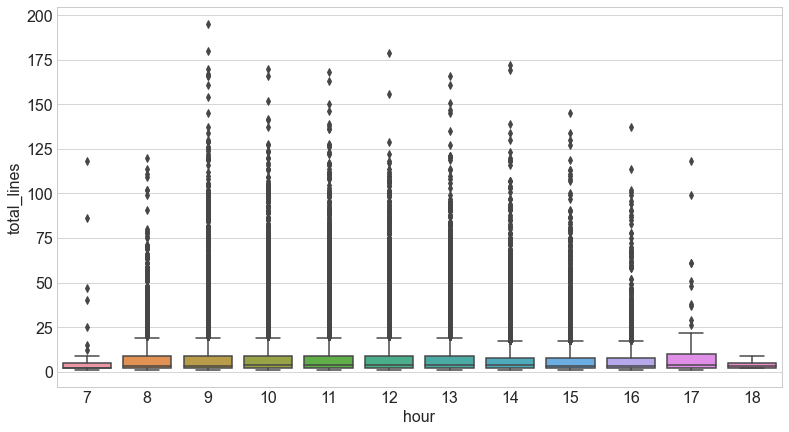

In [14]:
sns.boxplot(data=exp1, y='total_lines', x='hour')

### does the total lines vary by day of week?
- not much on average, but there seem to be a lot of outliers?

In [ ]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_lines', x='day_name', order=order)

### does the total lines vary by day of month?
- some variation on average by day of month
- first 4 days of month tend to be higher
- final days of month tend to be lower

In [ ]:
sns.boxplot(data=exp1, y='total_lines', x='day')

### does the total lines vary by week of year?
- Christmas and Thanksgiving weeks are lighter
- weeks at beginning of months are generally larger and weeks at end of month fewer

In [ ]:
sns.boxplot(data=exp1, y='total_lines', x='week')

### does the total lines vary by month of year?
- not really any variation by month

In [ ]:
sns.boxplot(data=exp1, y='total_lines', x='month')

### does the total lines vary by year?
- not really any variation by year

In [ ]:
sns.boxplot(data=exp1, y='total_lines', x='year')

### does the total boxes vary by day of week?
- only outliers?
- typically the boxes per pick is 1 so this may not be a good feature for analysis
- might need to treat values >1 as anomalies and remove from dataset?


In [ ]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_boxes', x='day_name', order=order)

# Time Series Explore

## Prepare time series dataframe

In [ ]:
ts.head()

In [ ]:
# create a dataframe with start as index and total lines, total boxes, and pick seconds as target
# these can all be aggregated by sum for resampling
pick = ts[['start', 'total_lines', 'total_boxes', 'pick_seconds']]
# set the index as start and sort for time series analysis
pick = pick.set_index('start').sort_index()

In [ ]:
pick.head()

## Basic range and histograms

without resampling

In [ ]:
pick.index.min(), pick.index.max()

In [ ]:
pick.hist(figsize=(9, 9))

In [ ]:
pick.total_lines.plot()

In [ ]:
pick.total_boxes.plot()

In [ ]:
pick.pick_seconds.plot()

## Find anomalies in pick seconds

In [ ]:
# get a df with just timeseries index and target
# for outlier dection sum by day to start (might need to do by hour if not granular enough)
pick_sec = pick[['pick_seconds']].resample('1d').sum()

In [ ]:
pick_sec.head()

### Simple Moving Average

In [ ]:
# get the 7 day rolling average
sma_short = pick_sec.rolling(window=7).mean()
# get the 30 day rolling average
sma_long = pick_sec.rolling(window=30).mean()

In [ ]:
# plot these
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pick_sec.index, pick_sec, label='pick_sec')

ax.plot(pick_sec.index, sma_short, label = '7-day SMA')

ax.plot(pick_sec.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

### Exponential Moving Average

In [ ]:
# use ewm to calculate EMA
ema_short = pick_sec.ewm(span=7).mean()
ema_long = pick_sec.ewm(span=30).mean()

In [ ]:
# plot these with SMA

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pick_sec.index, pick_sec, label='pick_sec', alpha=.5)

ax.plot(pick_sec.index, sma_short, label = '7-day SMA')
ax.plot(pick_sec.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pick_sec.index, pick_sec, label='pick_sec', alpha=.5)

ax.plot(pick_sec.index, sma_long, label = '30-day SMA')
ax.plot(pick_sec.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

plt.show()

### Bolinger bands and %b

In [ ]:
# set the window span - in this case 30 days
span = 30
# compute midband
midband = pick_sec.ewm(span=span).mean()
# compute exponential stdev
stdev = pick_sec.ewm(span=span).std()
# compute upper and lower bands, multiple the midband +/- 1.5 times the standard deviation
ub = midband + stdev*1.5
lb = midband - stdev*1.5
# NOTE: lower band would actually be zero, as it is not possible to have neagtive a pick time

In [ ]:
# plot the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pick_sec.index, 
        pick_sec,
        label='pick_sec')

ax.plot(pick_sec.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(pick_sec.index, 
        ub, 
        label = 'Upper Band')
ax.plot(pick_sec.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

In [ ]:
# concat the dataframes together
pick_sec_sum = pd.concat([pick_sec, midband, ub, lb], axis=1)
pick_sec_sum.columns = ['pick_sec', 'midband', 'ub', 'lb']
pick_sec_sum.tail()

In [ ]:
# add a calculated column for %b
pick_sec_sum['pct_b'] = (pick_sec_sum['pick_sec'] - pick_sec_sum['lb'])/(pick_sec_sum['ub'] - pick_sec_sum['lb'])

In [ ]:
# show anywhere %b is more than 1 = outside the upper band
len(pick_sec_sum[pick_sec_sum['pct_b']>1])

In [ ]:
# show anywhere %b is less than .1 = right at the lower band
len(pick_sec_sum[pick_sec_sum['pct_b']<.1])

In [ ]:
pick_sec_sum[pick_sec_sum['pct_b']<.1]

**takeaways**
- with 3 as the multiplier there are no results outside of the bands
- changing multiplier to 1.5
- drop 274 days with a pick time of 0 sec?
    - these are Saturdays, holidays, and possibly inventory days based on dates
    - they are generated from resampling 
    
- there are 51 rows with pick times above the upper band at 1.5
    - but this is a sum of the total pick seconds per day, these may be a result of adding operators to that day?
    - would need to add %b values to df with operators and look at those specific days
    - especially given they are within range when multiplier is 3

## Resample by Hour - RETURN HERE

In [ ]:
pick.resample('H').sum()

In [ ]:
pick.isna().sum()

## Resample by Day

In [ ]:
pick.resample('D').sum()